In [63]:
pip install gymnasium tensorflow numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [64]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from collections import deque
import random
import matplotlib.pyplot as plt

In [65]:
# Hyperparameters
env_name = "CartPole-v1"
episodes = 500  # More episodes for better convergence
gamma = 0.99  # Discount factor for long-term rewards
max_steps_per_episodes = 500 # avoid infinite loop
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Slower decay for more exploration
learning_rate = 0.0005  # Smaller learning rate for stability
batch_size = 64  # Large enough for stable training
memory_size = 100000  # Replay buffer size for diverse training samples
target_update_freq = 5  # Update target network every 5 episodes

In [66]:
# Environment
env = gym.make(env_name)
state_shape = env.observation_space.shape[0]
action_size = env.action_space.n

In [67]:
# Replay Buffer
memory = deque(maxlen=memory_size)

In [68]:
# Build Q-Network
def build_model():
    model = Sequential([
        Dense(64, activation="relu", input_shape=(state_shape,)),  # Increased layer size for better representation
        Dense(64, activation="relu"),  # More neurons for more complex learning
        Dense(action_size, activation="linear")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss=tf.keras.losses.MeanSquaredError())
    return model

In [69]:
q_network = build_model()
target_network = build_model()
target_network.set_weights(q_network.get_weights())

In [70]:
# Functions
def replay_experience():
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.array(states)
    next_states = np.array(next_states)
    targets = q_network.predict(states, verbose=0)
    target_next = target_network.predict(next_states, verbose=0)

    for i in range(batch_size):
        if dones[i]:
            targets[i, actions[i]] = rewards[i]
        else:
            targets[i, actions[i]] = rewards[i] + gamma * np.max(target_next[i])

    q_network.fit(states, targets, epochs=1, verbose=0)

In [71]:
# Tracking Metrics
rewards_history = []
epsilons = []

In [72]:
max_steps_per_episode = 500

for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    steps = 0  # Step counter

    while not done and steps < max_steps_per_episode:
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            q_values = q_network.predict(np.expand_dims(state, axis=0), verbose=0)
            action = np.argmax(q_values)

        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward

        memory.append((state, action, reward, next_state, done))
        state = next_state
        steps += 1  # Increment step counter

        replay_experience()

    rewards_history.append(total_reward)
    epsilons.append(epsilon)

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if episode % target_update_freq == 0:
        target_network.set_weights(q_network.get_weights())

    print(f"Episode {episode+1}/{episodes}: Total Reward = {total_reward}")


Episode 1/500: Total Reward = 16.0
Episode 2/500: Total Reward = 20.0
Episode 3/500: Total Reward = 16.0
Episode 4/500: Total Reward = 28.0
Episode 5/500: Total Reward = 27.0
Episode 6/500: Total Reward = 14.0
Episode 7/500: Total Reward = 29.0
Episode 8/500: Total Reward = 18.0
Episode 9/500: Total Reward = 18.0
Episode 10/500: Total Reward = 19.0
Episode 11/500: Total Reward = 34.0
Episode 12/500: Total Reward = 12.0
Episode 13/500: Total Reward = 14.0
Episode 14/500: Total Reward = 19.0
Episode 15/500: Total Reward = 15.0
Episode 16/500: Total Reward = 38.0
Episode 17/500: Total Reward = 23.0
Episode 18/500: Total Reward = 13.0
Episode 19/500: Total Reward = 22.0
Episode 20/500: Total Reward = 17.0
Episode 21/500: Total Reward = 45.0
Episode 22/500: Total Reward = 17.0
Episode 23/500: Total Reward = 11.0
Episode 24/500: Total Reward = 20.0
Episode 25/500: Total Reward = 10.0
Episode 26/500: Total Reward = 17.0
Episode 27/500: Total Reward = 31.0
Episode 28/500: Total Reward = 20.0
E

In [74]:
q_network.save("models/dqn_cartpole.keras")

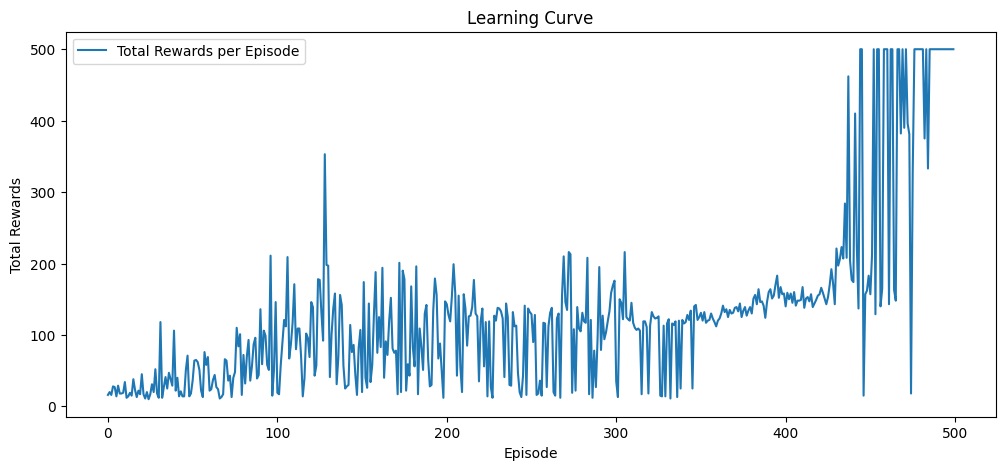

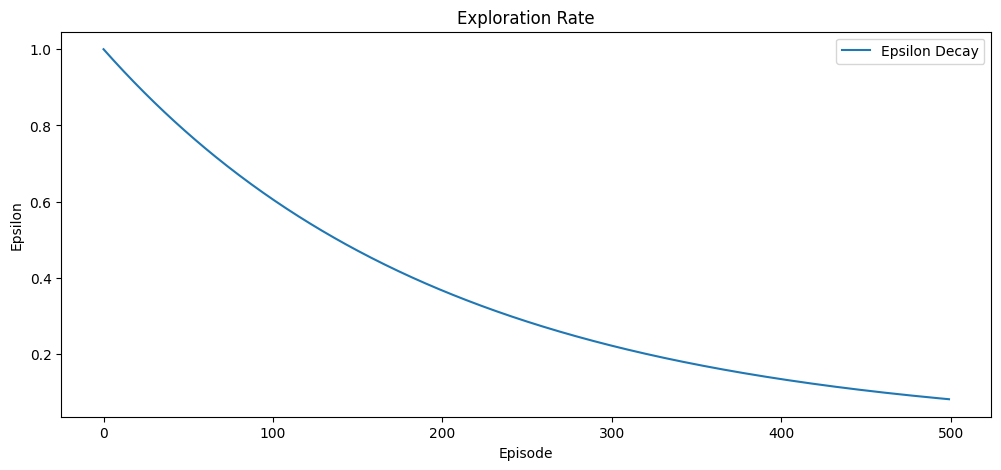

In [73]:
# Plot Learning Curve
plt.figure(figsize=(12, 5))
plt.plot(rewards_history, label="Total Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Rewards")
plt.title("Learning Curve")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(epsilons, label="Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Exploration Rate")
plt.legend()
plt.show()